## Multi Head Attention

In [53]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

In [100]:
sequence_length = 4
batch_size = 1
input_dim = 4
d_model = 6
x = torch.randn( (batch_size, sequence_length, input_dim) )

In [101]:
x.size()

torch.Size([1, 4, 4])

In [102]:
qkv_layer = nn.Linear(input_dim , 3 * d_model)

In [103]:
qkv = qkv_layer(x)

In [104]:
qkv.shape

torch.Size([1, 4, 18])

Text(0.5, 1.0, 'qkv distribution')

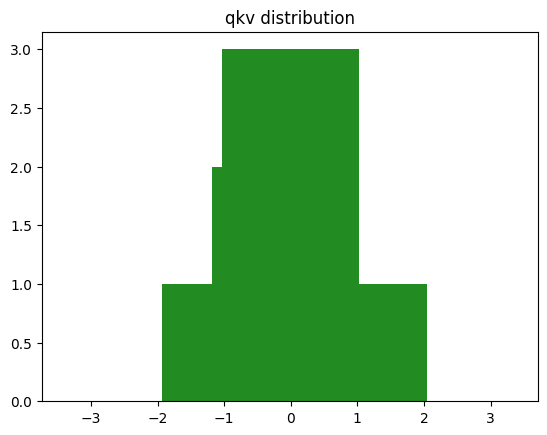

In [105]:
import matplotlib.pyplot as plt
y_val = torch.histc(qkv, bins=200, min=-3, max=3)
x_val = np.arange(-1, 1, 0.01) * 3
plt.bar(x_val, y_val, align='center', color=['forestgreen'])
plt.title('qkv distribution')

In [106]:
d_model

6

In [109]:
num_heads = 3
head_dim = d_model // num_heads
qkv = qkv.reshape(batch_size, sequence_length, num_heads, 3 * head_dim)

In [111]:
qkv.shape

torch.Size([1, 4, 3, 6])

In [112]:
qkv.shape

torch.Size([1, 4, 3, 6])

In [49]:
qkv = qkv.permute(0, 2, 1, 3) # [batch_size, num_heads, sequence_length, 3*head_dim]
qkv.shape

torch.Size([4, 8, 4, 192])

In [84]:
q, k, v = qkv.chunk(3, dim=-1)
q.shape, k.shape, v.shape

(torch.Size([4, 8, 4, 64]),
 torch.Size([4, 8, 4, 64]),
 torch.Size([4, 8, 4, 64]))

## Self Attention for multiple heads

For a single head:
$$
\text{self attention} = softmax\bigg(\frac{Q.K^T}{\sqrt{d_k}}+M\bigg)
$$

$$
\text{new V} = \text{self attention}.V
$$ 

In [55]:
d_k = q.size()[-1]
scaled = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)
scaled.shape

torch.Size([4, 8, 4, 4])

In [58]:
q.shape

torch.Size([4, 8, 4, 64])

In [59]:
k.T.shape

C:\Users\NH2091\AppData\Local\Temp\ipykernel_11276\3717780648.py:1: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3575.)
  k.T.shape


torch.Size([64, 4, 8, 4])

In [60]:
y = torch.randn(2, 3)
torch.transpose(y, 0, 1)

tensor([[-0.2859, -1.5363],
        [ 0.0175,  0.7000],
        [ 1.9211, -0.3058]])

In [61]:
torch.transpose(y, 1, 0)

tensor([[-0.2859, -1.5363],
        [ 0.0175,  0.7000],
        [ 1.9211, -0.3058]])

In [62]:
k.transpose(-1, -2) == k.transpose(-2, -1)

tensor([[[[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          ...,
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         [[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          ...,
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         [[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          ...,
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         ...,

         [[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          ...,
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         [[True, True, True, True],
          [True, 

In [63]:
k.transpose(-1, -2).shape

torch.Size([4, 8, 64, 4])

In [64]:
mask = torch.full(scaled.size() , float('-inf'))
mask = torch.triu(mask, diagonal=1)
mask[0][1] # mask for input to a single head

tensor([[0., -inf, -inf, -inf],
        [0., 0., -inf, -inf],
        [0., 0., 0., -inf],
        [0., 0., 0., 0.]])

In [65]:
(scaled + mask)[0][0]

tensor([[-3.7817e-01,        -inf,        -inf,        -inf],
        [-2.0877e-01,  1.9034e-01,        -inf,        -inf],
        [-4.4298e-01,  5.0880e-01,  2.5273e-01,        -inf],
        [-5.5707e-04, -7.6264e-01, -2.1010e-01,  1.2867e-01]],
       grad_fn=<SelectBackward0>)

In [66]:
scaled += mask

In [67]:
np.exp(0.5596) / (np.exp(0.5596) + np.exp(0.0404))

0.6269606805367254

In [68]:
attention = F.softmax(scaled, dim=-1)

In [69]:
attention.shape

torch.Size([4, 8, 4, 4])

In [70]:
attention[0][0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.4015, 0.5985, 0.0000, 0.0000],
        [0.1787, 0.4629, 0.3584, 0.0000],
        [0.2928, 0.1366, 0.2374, 0.3332]], grad_fn=<SelectBackward0>)

In [71]:
values = torch.matmul(attention, v)
values.shape

torch.Size([4, 8, 4, 64])

## Function

In [72]:
import math

def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k)
    if mask is not None:
        scaled += mask
    attention = F.softmax(scaled, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

In [73]:
values, attention = scaled_dot_product(q, k, v, mask=mask)

In [74]:
attention.shape

torch.Size([4, 8, 4, 4])

In [75]:
attention[0][0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.4015, 0.5985, 0.0000, 0.0000],
        [0.1787, 0.4629, 0.3584, 0.0000],
        [0.2928, 0.1366, 0.2374, 0.3332]], grad_fn=<SelectBackward0>)

In [76]:
values.size()

torch.Size([4, 8, 4, 64])

In [77]:
values = values.reshape(batch_size, sequence_length, num_heads * head_dim)
values.size()

torch.Size([4, 4, 512])

In [78]:
linear_layer = nn.Linear(d_model, d_model)

In [79]:
out = linear_layer(values)

In [80]:
out.shape

torch.Size([4, 4, 512])

In [81]:
out

tensor([[[-0.1460, -0.4437,  0.3299,  ..., -0.1027,  0.2071,  0.4048],
         [-0.4781, -0.1908, -0.2199,  ...,  0.1160, -0.0903,  0.2033],
         [-0.0061, -0.0629, -0.0979,  ...,  0.2954, -0.2578, -0.2498],
         [-0.3343,  0.3235,  0.2467,  ...,  0.2319,  0.0143, -0.1241]],

        [[ 0.3411, -0.0219, -0.3118,  ...,  0.3943,  0.2416, -0.1059],
         [-0.1558, -0.1289,  0.3654,  ...,  0.0781, -0.1360, -0.0658],
         [-0.3007,  0.0847, -0.2209,  ..., -0.1745, -0.1231,  0.2222],
         [ 0.0548,  0.2282,  0.0033,  ..., -0.1183, -0.1838,  0.3323]],

        [[ 0.5242,  0.2897, -0.2201,  ..., -0.0619, -0.1812, -0.4211],
         [ 0.3865, -0.5457, -0.0801,  ..., -0.1175, -0.0403,  0.1935],
         [ 0.1393, -0.1597,  0.4671,  ..., -0.0283,  0.2709,  0.0390],
         [ 0.3024,  0.3523, -0.0506,  ..., -0.3048,  0.1508,  0.6844]],

        [[-0.0878,  0.0008, -0.7466,  ...,  0.0776, -0.0013,  0.1287],
         [-0.0571,  0.2748,  0.1312,  ...,  0.1070,  0.0786,  0.4032],


## Class

In [82]:
import torch
import torch.nn as nn
import math

def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k)
    if mask is not None:
        scaled += mask
    attention = F.softmax(scaled, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

class MultiheadAttention(nn.Module):

    def __init__(self, input_dim, d_model, num_heads):
        super().__init__()
        self.input_dim = input_dim
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.qkv_layer = nn.Linear(input_dim , 3 * d_model)
        self.linear_layer = nn.Linear(d_model, d_model)
    
    def forward(self, x, mask=None):
        batch_size, sequence_length, input_dim = x.size()
        print(f"x.size(): {x.size()}")
        qkv = self.qkv_layer(x)
        print(f"qkv.size(): {qkv.size()}")
        qkv = qkv.reshape(batch_size, sequence_length, self.num_heads, 3 * self.head_dim)
        print(f"qkv.size(): {qkv.size()}")
        qkv = qkv.permute(0, 2, 1, 3)
        print(f"qkv.size(): {qkv.size()}")
        q, k, v = qkv.chunk(3, dim=-1)
        print(f"q size: {q.size()}, k size: {k.size()}, v size: {v.size()}, ")
        values, attention = scaled_dot_product(q, k, v, mask)
        print(f"values.size(): {values.size()}, attention.size:{ attention.size()} ")
        values = values.reshape(batch_size, sequence_length, self.num_heads * self.head_dim)
        print(f"values.size(): {values.size()}")
        out = self.linear_layer(values)
        print(f"out.size(): {out.size()}")
        return out


## Input

In [83]:
input_dim = 1024
d_model = 512
num_heads = 8

batch_size = 30
sequence_length = 5
x = torch.randn( (batch_size, sequence_length, input_dim) )

model = MultiheadAttention(input_dim, d_model, num_heads)
out = model.forward(x)

x.size(): torch.Size([30, 5, 1024])
qkv.size(): torch.Size([30, 5, 1536])
qkv.size(): torch.Size([30, 5, 8, 192])
qkv.size(): torch.Size([30, 8, 5, 192])
q size: torch.Size([30, 8, 5, 64]), k size: torch.Size([30, 8, 5, 64]), v size: torch.Size([30, 8, 5, 64]), 
values.size(): torch.Size([30, 8, 5, 64]), attention.size:torch.Size([30, 8, 5, 5]) 
values.size(): torch.Size([30, 5, 512])
out.size(): torch.Size([30, 5, 512])


In [114]:
embedding_dim=12
attention_dim=3

In [143]:
query=nn.Linear(embedding_dim,attention_dim, bias=False)
key=nn.Linear(embedding_dim,attention_dim,bias=False)
value=nn.Linear(embedding_dim,attention_dim,bias=False)


In [144]:
b=1
s=4
i=12
embedded=torch.randn((b,s,i))

In [145]:
q=query(embedded)
k=key(embedded)
v=value(embedded)

In [146]:
q.shape

torch.Size([1, 4, 3])

In [147]:
attn_len,context_len=q.shape[-1],q.shape[-2]

In [162]:
scores=torch.matmul(q,k.transpose(-2,-1))/attn_len**(0.5)

In [163]:
embedded

tensor([[[ 0.2294,  1.8679, -0.4667,  2.2280,  0.1020, -0.7011,  0.0622,
           0.3732,  1.0044,  0.1114, -0.5365,  1.5790],
         [-1.1151,  2.7913, -0.0406,  1.4016, -0.3440, -1.5138,  1.1701,
          -2.8675, -0.8803,  0.9443,  0.7478, -0.2396],
         [-0.6904,  0.3364, -1.8404,  1.0603,  0.0513, -0.0158,  0.4949,
          -0.5014, -0.8195, -0.6751, -0.2116,  0.3811],
         [-0.2394,  0.2485,  0.0509,  0.2072,  0.7934, -1.1592, -1.1003,
           0.2354, -0.2723, -1.3261, -1.2496,  0.9633]]])

In [172]:
lower_triangular = torch.tril(torch.ones(context_len, context_len))

In [173]:
lower_triangular

tensor([[1., 0., 0., 0.],
        [1., 1., 0., 0.],
        [1., 1., 1., 0.],
        [1., 1., 1., 1.]])

In [174]:
# torch.ones(context_len, context_len)

In [175]:
mask = lower_triangular == 0
scores = scores.masked_fill(mask, float('-inf'))
scores = nn.functional.softmax(scores, dim = 2)

In [176]:
scores

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.4975, 0.5025, 0.0000, 0.0000],
         [0.3136, 0.3638, 0.3226, 0.0000],
         [0.2576, 0.2294, 0.2477, 0.2654]]], grad_fn=<SoftmaxBackward0>)

In [179]:
new_embed=torch.matmul(scores,v)

In [181]:
new_embed=torch.round(new_embed,decimals=4)

In [182]:
new_embed

tensor([[[-0.2033,  0.2665, -0.2036],
         [ 0.1566,  0.3518,  0.7729],
         [ 0.0982,  0.1880,  0.8601],
         [-0.0037,  0.1493,  0.5442]]], grad_fn=<RoundBackward1>)

In [461]:
class SelfAttn(nn.Module):
    
    def __init__(self,batch,seq_len,embed_dim,attn_dim,num_heads=1):
        super().__init__()
        self.batch=batch
        self.seq_len=seq_len
        self.embed_dim=embed_dim
        self.attn_dim=attn_dim
        self.num_heads=3
        
        
        self.query=nn.Linear(embed_dim,attn_dim*num_heads)
        
        self.key=nn.Linear(embed_dim,attn_dim*num_heads)
        
        self.value=nn.Linear(embed_dim,attn_dim*num_heads)
        
        
    def forward(self,embedded,add=False):
        
        print(embedded.shape)
        
        q=self.query(embedded).view(self.batch,self.seq_len,self.num_heads,self.attn_dim).transpose(1,2)
        k=self.key(embedded).view(self.batch,self.seq_len,self.num_heads,self.attn_dim).transpose(1,2)
        v=self.value(embedded).view(self.batch,self.seq_len,self.num_heads,self.attn_dim).transpose(1,2)
        
        print(q.shape,k.shape,v.shape)
        

        scores=torch.matmul(q,k.transpose(-2,-1))/(self.attn_dim)**(0.5)
                
        lower_tr=torch.tril(torch.ones(self.seq_len,self.seq_len))
        
        print(scores.shape,lower_tr.shape)
        
        mask=lower_tr==0
                
        scores = scores.masked_fill(mask, float('-inf'))
        
        
        scores_scaled=nn.functional.softmax(scores,dim=-1)
        
        print(scores_scaled)

        
        ans=torch.round(torch.matmul(scores_scaled,v),decimals=4)
        
        # Concatenate heads
        attn_output = ans.transpose(1, 2).contiguous().view(self.batch, self.seq_len, -1)  # [batch_size, seq_len, num_heads * attn_dim]
        
        
        if add:
            ans=v+ans
            
        # Normalize the output
        mean = torch.mean(attn_output, dim=-1, keepdim=True)
        std = torch.std(attn_output, dim=-1, keepdim=True)
        normalized_output = (attn_output - mean) / std

        return normalized_output, scores_scaled    
            
     

In [462]:
a=SelfAttn(2,5,12,4,3)

In [463]:
a

SelfAttn(
  (query): Linear(in_features=12, out_features=12, bias=True)
  (key): Linear(in_features=12, out_features=12, bias=True)
  (value): Linear(in_features=12, out_features=12, bias=True)
)

In [464]:
b=2
s=5
e_d=12
X=torch.randn((b,s,e_d))

In [465]:
X.shape

torch.Size([2, 5, 12])

In [466]:
sc=a.forward(X,False)

torch.Size([2, 5, 12])
torch.Size([2, 3, 5, 4]) torch.Size([2, 3, 5, 4]) torch.Size([2, 3, 5, 4])
torch.Size([2, 3, 5, 5]) torch.Size([5, 5])
tensor([[[[1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.4185, 0.5815, 0.0000, 0.0000, 0.0000],
          [0.3843, 0.2562, 0.3596, 0.0000, 0.0000],
          [0.2547, 0.2947, 0.2263, 0.2242, 0.0000],
          [0.1800, 0.2383, 0.1709, 0.2516, 0.1592]],

         [[1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.5123, 0.4877, 0.0000, 0.0000, 0.0000],
          [0.3015, 0.3739, 0.3247, 0.0000, 0.0000],
          [0.4486, 0.2695, 0.1074, 0.1745, 0.0000],
          [0.0890, 0.1591, 0.3737, 0.2220, 0.1563]],

         [[1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.3769, 0.6231, 0.0000, 0.0000, 0.0000],
          [0.4126, 0.3807, 0.2067, 0.0000, 0.0000],
          [0.2095, 0.1978, 0.3233, 0.2693, 0.0000],
          [0.2141, 0.3499, 0.1431, 0.1841, 0.1088]]],


        [[[1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.3154,

In [474]:
sc[0]

tensor([[[ 0.6752,  0.4766,  0.4773, -0.4771, -1.7998, -0.2166,  1.2526,
           1.1934, -1.6441,  0.1241,  0.6257, -0.6873],
         [ 1.7380,  0.4347,  0.3487, -0.9242, -0.5140, -0.7274,  0.5186,
          -0.0228, -0.6842,  1.0468,  0.7063, -1.9207],
         [ 1.3987,  0.1305,  0.7149, -0.4620, -1.2054, -0.2931,  0.4280,
           0.0830, -0.9554,  1.2193,  0.8149, -1.8734],
         [ 1.3249,  0.5485,  0.6543, -0.1429, -1.4820, -0.4164,  1.4353,
           0.7147, -0.9462,  0.3472, -0.5375, -1.5000],
         [ 1.1955,  0.0403, -0.0410, -1.0374, -1.6700,  0.7623,  0.2293,
           0.6755, -0.7272,  1.3561,  0.5927, -1.3760]],

        [[ 0.6306, -0.9708,  0.1337, -1.9162,  0.1721,  0.6580, -0.5153,
           0.0463,  0.5335, -0.0995, -0.7616,  2.0893],
         [ 1.2208,  0.6294, -1.0444, -1.2848,  0.3988, -1.0714,  0.6707,
           0.3236, -1.6195,  0.1302,  0.3157,  1.3308],
         [ 0.7627, -0.3102, -1.4918, -1.5958,  0.7164, -0.4190,  0.8189,
           0.4622, -1.

In [468]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SelfAttn(nn.Module):
    def __init__(self, batch, seq_len, embed_dim, attn_dim, num_heads=1):
        super().__init__()
        self.batch = batch
        self.seq_len = seq_len
        self.embed_dim = embed_dim
        self.attn_dim = attn_dim
        self.num_heads = num_heads

        self.query = nn.Linear(embed_dim, attn_dim * num_heads)
        self.key = nn.Linear(embed_dim, attn_dim * num_heads)
        self.value = nn.Linear(embed_dim, attn_dim * num_heads)
        
        self.scale_factor = attn_dim ** 0.5

    def forward(self, embedded):
        batch_size = embedded.size(0)

        # Linear projections
        q = self.query(embedded).view(batch_size, self.seq_len, self.num_heads, self.attn_dim)
        k = self.key(embedded).view(batch_size, self.seq_len, self.num_heads, self.attn_dim)
        v = self.value(embedded).view(batch_size, self.seq_len, self.num_heads, self.attn_dim)

        # Transpose for attention calculation
        q = q.transpose(1, 2)  # (batch_size, num_heads, seq_len, attn_dim)
        k = k.transpose(1, 2)  # (batch_size, num_heads, seq_len, attn_dim)
        v = v.transpose(1, 2)  # (batch_size, num_heads, seq_len, attn_dim)

        # Scaled dot-product attention
        scores = torch.matmul(q, k.transpose(-2, -1)) / self.scale_factor
        
        # Masking to prevent attending to future tokens
        lower_tr = torch.tril(torch.ones(self.seq_len, self.seq_len, device=scores.device))
        mask = lower_tr == 0
        scores = scores.masked_fill(mask, float('-inf'))
        
        # Softmax to get attention probabilities
        attn_probs = F.softmax(scores, dim=-1)
        
        # Attention output
        attn_output = torch.matmul(attn_probs, v)  # (batch_size, num_heads, seq_len, attn_dim)
        
        # Concatenate heads and round results
        attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, self.seq_len, -1)
        
        # Round to the specified number of decimals
        decimals = 4
        scaling_factor = 10 ** decimals
        attn_output = torch.round(attn_output * scaling_factor) / scaling_factor
        
        return attn_output

# Example usage
batch = 2
seq_len = 3
embed_dim = 4
attn_dim = 2
num_heads = 2

self_attn = SelfAttn(batch, seq_len, embed_dim, attn_dim, num_heads)
embedded = torch.randn(batch, seq_len, embed_dim)
output = self_attn(embedded)
print(output)


tensor([[[ 0.1590,  0.2226,  0.7693, -0.0558],
         [-0.3940, -0.2064,  0.3827, -0.1066],
         [-0.2045, -0.2629, -0.0982, -0.3237]],

        [[-0.7310, -0.0329,  0.0635, -0.3970],
         [-0.2958, -0.0576,  0.2643, -0.4464],
         [ 0.1081, -0.0764,  0.3632, -0.5046]]], grad_fn=<DivBackward0>)


In [429]:
output.shape

torch.Size([2, 3, 4])

In [583]:
import torch
import torch.nn as nn
# from torchtyping import TensorType

class Solution(nn.Module):
    def __init__(self, vocabulary_size: int):
        super().__init__()
        torch.manual_seed(0)
        
        self.embedding_layer=nn.Embedding(vocabulary_size,16)

        self.linear_layer=nn.Linear(16,1)

        self.sigmoid_layer=nn.Sigmoid()

    def forward(self, x) :
        # Hint: The embedding layer outputs a B, T, embed_dim tensor
        # but you should average it into a B, embed_dim tensor before using the Linear layer
        embeddings=self.embedding_layer(x)
        
#         return embeddings
        
        averaged=torch.mean(embeddings, axis=2)
        
#         return averaged

        projected=self.linear_layer(averaged)

        return torch.round(self.sigmoid_layer(projected),decimals=2)
        # Return a B, 1 tensor and round to 4 decimal places


In [584]:
s=Solution(10000)

In [585]:
x = torch.tensor([[
 [2.0, 7.0, 14.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],    
[1.0, 4.0, 12.0, 3.0, 10.0, 5.0, 15.0, 11.0, 6.0, 9.0, 13.0, 7.0]],
    
[[26.0, 7.0, 14.0, 8.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],    
[1.0, 4.0, 12.0, 3.0, 9.0, 5.0, 15.0, 11.0, 6.0, 9.0, 13.0, 7.0]]
],
    dtype=torch.long)

C:\Users\NH2091\AppData\Local\Temp\ipykernel_11276\174707659.py:1: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  x = torch.tensor([[


In [586]:
x.shape

torch.Size([2, 2, 12])

In [587]:
k=s.forward(x)

In [588]:
k.shape

torch.Size([2, 2, 1])

In [589]:
k.shape

torch.Size([2, 2, 1])

In [590]:
k[0].shape

torch.Size([2, 1])

In [591]:
k[0][1]

tensor([0.4800], grad_fn=<SelectBackward0>)

In [594]:
k[1]

tensor([[0.6000],
        [0.4800]], grad_fn=<SelectBackward0>)

In [605]:
a=[1,2,3,4]
b=[4,5,6,3]

In [606]:
a=np.array(a)
b=np.array(b)

In [607]:
a

array([1, 2, 3, 4])

In [619]:
a%b


def softmax(x):
    val=1/(1+np.exp(-x))
    
    return val
 

In [625]:
softmax(np.dot(a,b)/(np.linalg.norm(a)*np.linalg.norm(b)))

0.7039646260537472

In [626]:
np.linalg.norm(a)

5.477225575051661

In [627]:
a

array([1, 2, 3, 4])

In [628]:
np.dot(a,b)/(np.linalg.norm(a)*np.linalg.norm(b))

0.8662491540539735

In [611]:
b

array([4, 5, 6, 3])

In [629]:
torch.dot

<function torch._VariableFunctionsClass.dot>

In [631]:
torch.dot(torch.randn(5),torch.randn(5))/5

tensor(0.2096)